# Image preprocessing examples
This notebook contains preprocessing methods used during experiments. Each method can be tested with random images from the dataset, the original and modified image are visualised for comparison. Preprocessing methods implementation is in ***image_preprocessing.py*** file. See it for further information.

In [81]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from utils import get_dataframe
from image_preprocessing import *

# Constants and setup

In [2]:
DATASET_PATH = '../datasets/tvt_detailed_paths.csv' # Path to csv file with dataset information (train-valid-test split)
MURA_DIR = '../datasets/original/' # Directory with original MURA dataset (unmodified images)

# Load desired portion of the dataset
df = get_dataframe('ALL', 'train', DATASET_PATH)

def get_rand_img():
    """
    Returns one image at random, prints chosen image filepath
    """
    rand_path = MURA_DIR + df.sample(n=1).filepath.item()
    print('Path to random image:', rand_path)
    return cv2.imread(rand_path)

# CLAHE vs HE comparison

In [233]:
def clahe_vs_he(img, clip, save=False):
    """
    Modifies image using CLAHE and Histogram equalization and displays original and modified images
    
    Parameters
    ----------
    img: numpy.ndarray
        Image to be modified
    clip: float
        Clip limit used by CLAHE
    save: bool
        Whether to save the visualisation or not
    """
    clahe_img = clahe(img, clip=clip, tile=(8,8))
    hist_img = eq_hist(img)

    fig, ax = plt.subplots(1, 3, figsize=(18, 10))
    fig.tight_layout()

    ax[0].imshow(img)
    ax[0].set_title("Original", fontsize=18, y=-0.08)


    ax[1].imshow(hist_img)
    ax[1].set_title("Histogram equalization", fontsize=18, y=-0.08)

    ax[2].imshow(clahe_img)
    ax[2].set_title(f"CLAHE (clipLimit={clip})", fontsize=18, y=-0.08)

    for axis in ax:
        axis.axis('off')
    plt.show()
    
    # Optional - save comparison as an image
    if save:
        plt.savefig('../figures/hist_clahe_comp.jpg')

## Running CLAHE vs HE comparison

Path to random image: ../datasets/original/MURA-v1.1/train/XR_WRIST/patient08904/study1_negative/image1.png


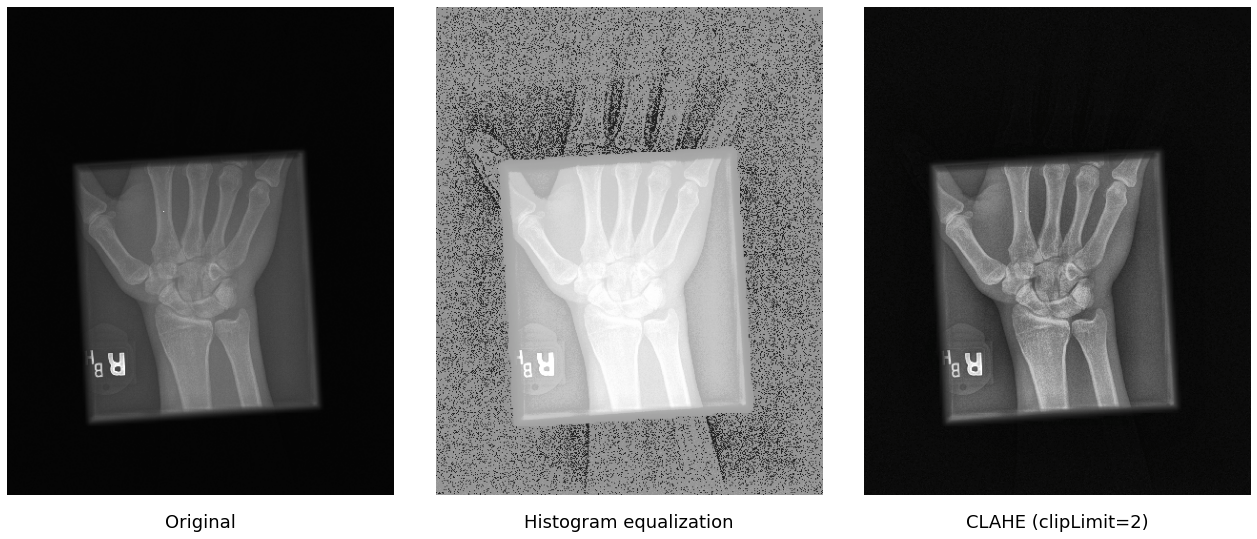

In [11]:
img = get_rand_img() # Replace if you don't want to use random image
clahe_vs_he(img=img, clip=2)

# CLAHE parameters comparison

In [234]:
def clahe_comp(img, config_1, config_2, save=False):
    """
    Modifies image using two different CLAHE configurations and displays the results
    
    Parameters
    ----------
    img: numpy.ndarray
        Image to be modified
    config_1: dict
        Parameters for first CLAHE application, the dictionary format should be the following:
        {'clip': float, 'tile'=(x, x)}, x being an int
    config_2: dict
        Parameters for second CLAHE application, following the same dictionary format
    save: bool
        Whether to save the visualisation or not
    """
    clahe_img_1 = clahe(img, clip=config_1['clip'], tile=config_1['tile'])
    clahe_img_2 = clahe(img, clip=config_2['clip'], tile=config_2['tile'])

    fig, ax = plt.subplots(1, 3, figsize=(18, 10))
    fig.tight_layout()

    ax[0].imshow(img)
    ax[0].set_title("Original", fontsize=18, y=-0.08)


    ax[1].imshow(clahe_img_1)
    ax[1].set_title(f"CLAHE (clipLimit={config_1['clip']}, tile={config_1['tile']})", fontsize=18, y=-0.08)

    ax[2].imshow(clahe_img_2)
    ax[2].set_title(f"CLAHE (clipLimit={config_2['clip']}, tile={config_2['tile']})", fontsize=18, y=-0.08)

    for axis in ax:
        axis.axis('off')
    plt.show()
    
    # Optional - save comparison as an image
    if save:
        plt.savefig('../figures/clahe_comp.jpg')

## Running CLAHE comparison

Path to random image: ../datasets/original/MURA-v1.1/train/XR_WRIST/patient06888/study1_positive/image3.png


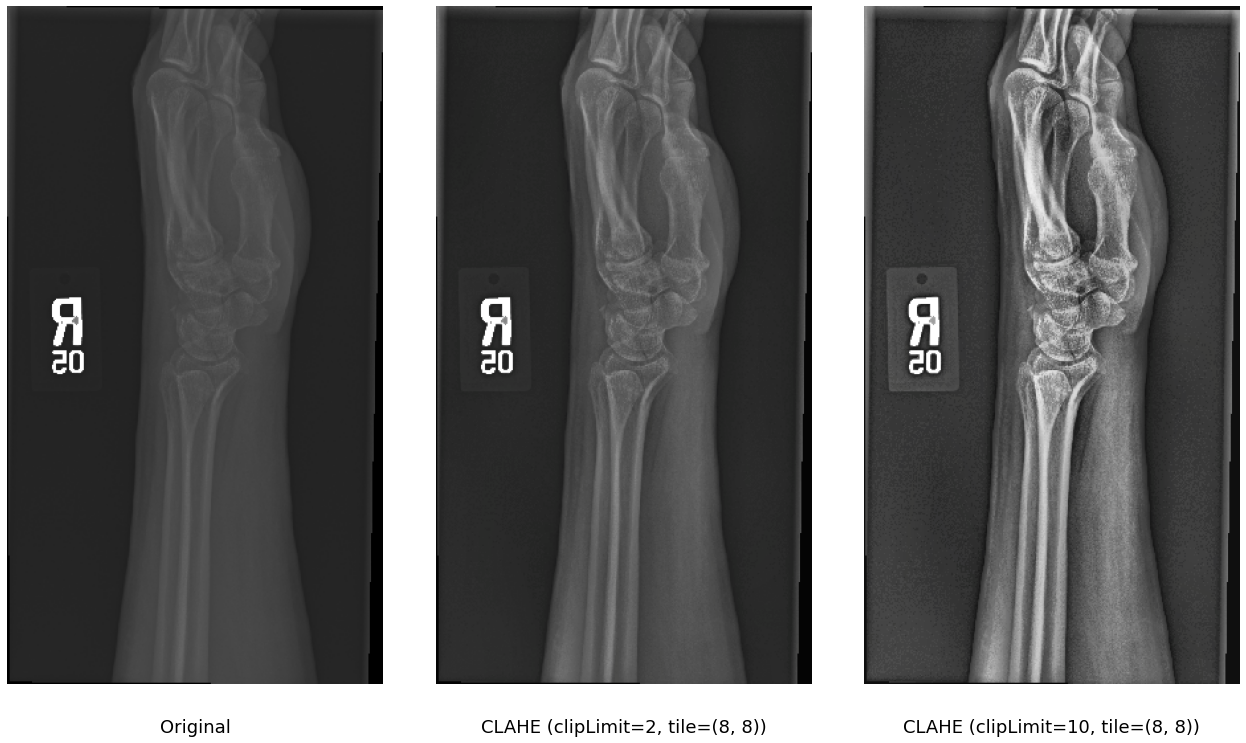

In [9]:
img = get_rand_img() # Replace if you don't want to use random image
config_1 = {'clip': 2, 'tile': (8,8)}
config_2 = {'clip': 10, 'tile': (8,8)}
clahe_comp(img, config_1, config_2)

# Image cropping
I created a custom preprocessing function that crops the image multiple times trying to separate the important region of the image, applying other changes to the image in the process. The function below visualizes the steps taken.

In [84]:
def show_image_crop_process(images, box_ratio=0.05, contour_ratio=0.3, save=False):
    """
    Apply custom image cropping preprocessing function to multiple images and display the stepts taken. Each plotted
    row corresponds to one image. Uses function image_crop from image_preprocessing.py.
    
    Parameters
    ----------
    images: list
        Numpy ndarrays representing images to be preprocessed
    box_ratio: float
        Determines minimal portion of the image area the bounding rectangle must cover in order for the image
        to be cropped
    contour_ratio: float
        Determines minimal portion of the image area the convex hull must cover in order for the mask to be applied
    save: bool
        Whether to save the created visualization or not
    """
    results = []
    # Get results for all images
    for image in images:
        results.append(image_crop(image, box_ratio, contour_ratio, True)) 
    
    # Setup subplots
    if len(images) == 1:
        fig, ax = plt.subplots(1, 6, figsize=(20, 8))
    else:    
        x_fig = 16 + 4*len(images)
        y_fig = 8 + 6*len(images)
        fig, ax = plt.subplots(len(images), 6, figsize=(x_fig, y_fig))
    
    [axis.set_xticks([]) for axis in ax.ravel()]
    [axis.set_yticks([]) for axis in ax.ravel()]
    
    # Single image mode
    if len(images) == 1:
        s_fontsize = 14
        ax[0].set_title('Original image', fontsize=s_fontsize)
        ax[1].set_title('Inversion, CLAHE\nand gaussian blur', fontsize=s_fontsize)
        ax[2].set_title('Bounding rectangle', fontsize=s_fontsize)
        ax[3].set_title('Cropped image', fontsize=s_fontsize)
        ax[4].set_title('Convex hull', fontsize=s_fontsize)
        ax[5].set_title('Final image', fontsize=s_fontsize)
       
        ax[0].imshow(results[0][0])
        ax[1].imshow(results[0][1], cmap='gray')
        ax[2].imshow(results[0][2])
        ax[3].imshow(results[0][3], cmap='gray')
        ax[4].imshow(results[0][4])
        ax[5].imshow(results[0][5], cmap='gray')
    # Multi-image mode
    else:
        m_fontsize = 18 + 2 * len(images)  
        ax[0, 0].set_title('Original image', fontsize=m_fontsize, y=1.1)
        ax[0, 1].set_title('Inversion, CLAHE\nand gaussian blur', fontsize=m_fontsize, y=1.1)
        ax[0, 2].set_title('Bounding rectangle', fontsize=m_fontsize, y=1.1)
        ax[0, 3].set_title('Cropped image', fontsize=m_fontsize, y=1.1)
        ax[0, 4].set_title('Convex hull', fontsize=m_fontsize, y=1.1)
        ax[0, 5].set_title('Final image', fontsize=m_fontsize, y=1.1)

        for i in range(0, len(results)):
            if save:
                ax[i, 0].set_ylabel(chr(97+i) + ')', fontsize=m_fontsize * 1.5, rotation=0, labelpad=40)
            ax[i, 0].imshow(results[i][0])
            ax[i, 1].imshow(results[i][1], cmap='gray')
            ax[i, 2].imshow(results[i][2])
            ax[i, 3].imshow(results[i][3], cmap='gray')
            ax[i, 4].imshow(results[i][4])
            ax[i, 5].imshow(results[i][5], cmap='gray')
    
    if save:
        plt.savefig('../figures/custom_image_crop.jpg')
    plt.show()

# Visualize custom image cropping

In [78]:
# Manually selected list of image_paths used for displaying different preprocessing function behaviors,
prepared_paths = [
        '../datasets/original/MURA-v1.1/train/XR_WRIST/patient07581/study1_negative/image2.png', # good cut
        '../datasets/original/MURA-v1.1/train/XR_SHOULDER/patient00572/study1_positive/image1.png', # succesfully removes text
        '../datasets/original/MURA-v1.1/train/XR_WRIST/patient08734/study1_negative/image3.png', # removing big background
        '../datasets/original/MURA-v1.1/train/XR_WRIST/patient06439/study1_positive/image1.png', # didnt cut small convex hull
        '../datasets/original/MURA-v1.1/train/XR_SHOULDER/patient02652/study1_negative/image1.png', # cuts out important part
        '../datasets/original/MURA-v1.1/train/XR_WRIST/patient07060/study2_negative/image1.png', # cuts out only one out of 3 hands
        ]

prepared_images = []
for path in prepared_paths:
    prepared_images.append(cv2.imread(path))

Path to random image: ../datasets/original/MURA-v1.1/train/XR_WRIST/patient02012/study1_negative/image2.png
Path to random image: ../datasets/original/MURA-v1.1/train/XR_WRIST/patient06663/study1_positive/image1.png
Path to random image: ../datasets/original/MURA-v1.1/train/XR_FOREARM/patient04021/study1_negative/image2.png
Path to random image: ../datasets/original/MURA-v1.1/train/XR_ELBOW/patient05598/study1_negative/image2.png
Path to random image: ../datasets/original/MURA-v1.1/train/XR_WRIST/patient06833/study1_positive/image2.png
Path to random image: ../datasets/original/MURA-v1.1/train/XR_SHOULDER/patient00316/study1_positive/image1.png


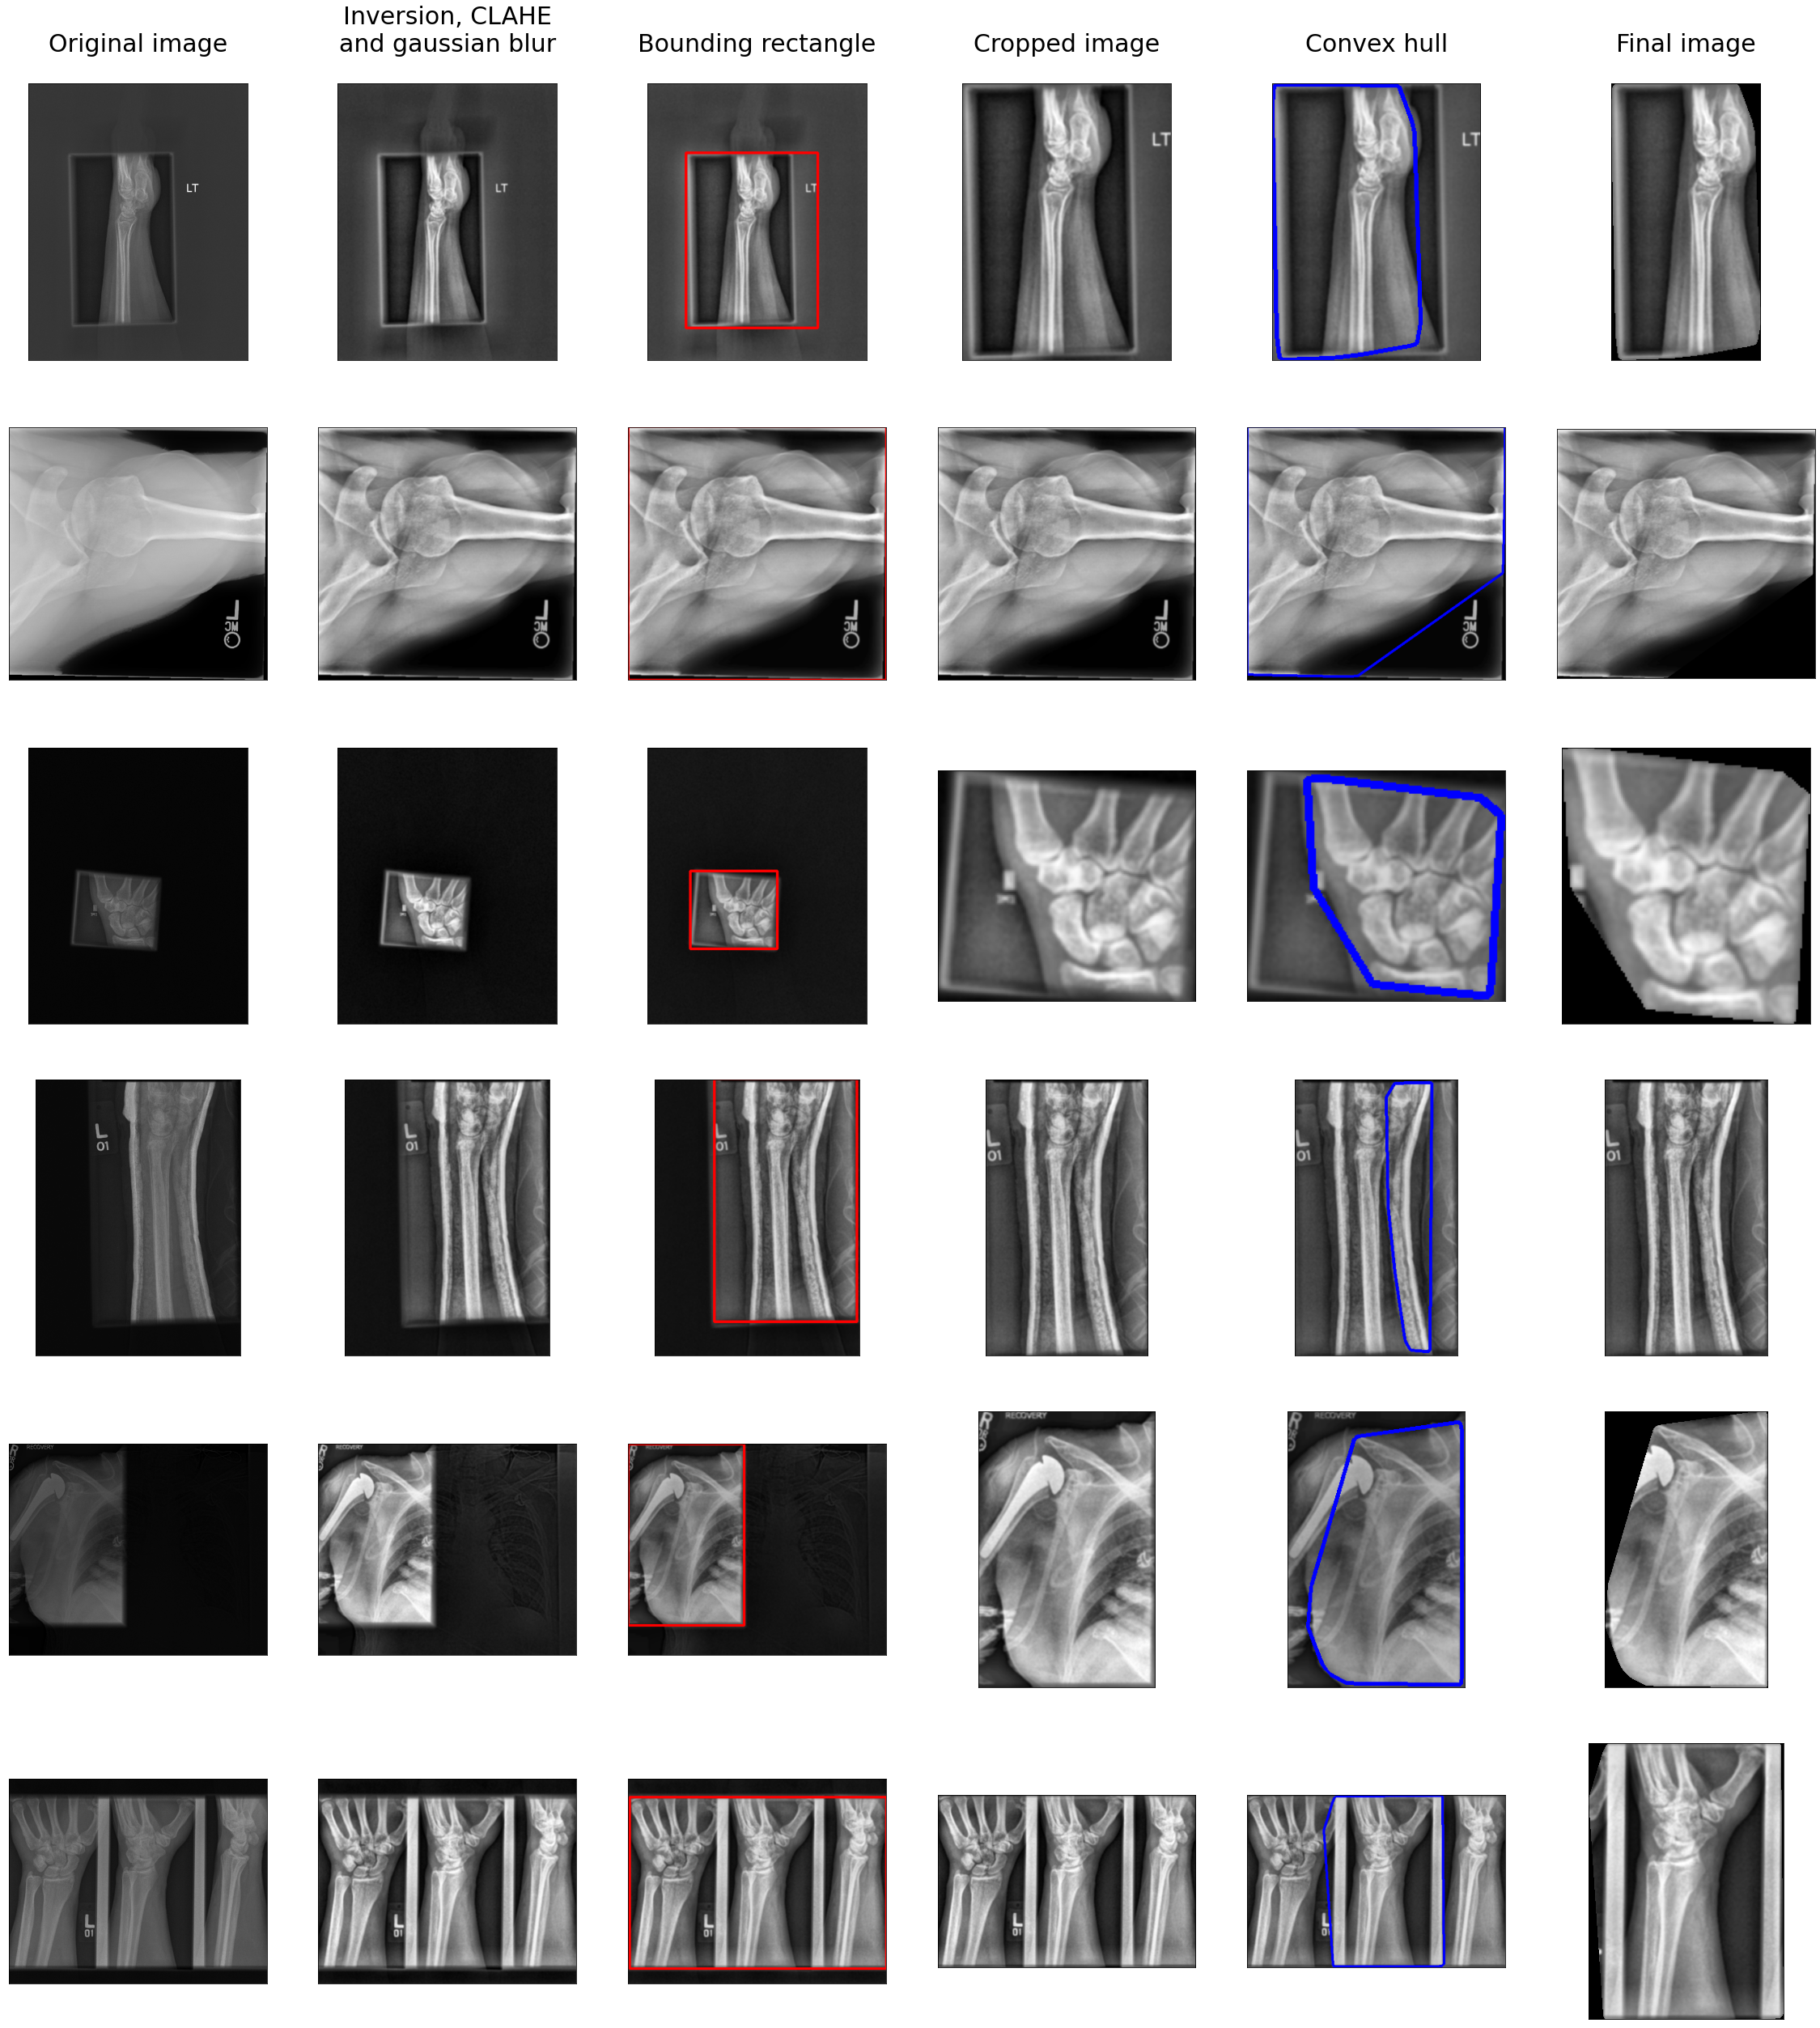

In [82]:
N_IMAGES = 6 # number of random images to be used
# Get random images
rand_images = []
for i in range(0,N_IMAGES):
    rand_images.append(get_rand_img())

# Run visualisation, use manually selected list, random images or a list of images created by you
show_image_crop_process(images=prepared_images, save=False)